#Tarea 3
#Ricardo Zamora Mennigke
#Métodos Calibración de Modelos

Pregunta 1: [25 puntos] En esta pregunta utiliza los datos (tumores.csv). Se trata de un conjunto de datos de caracter´ısticas del tumor cerebral que incluye cinco variables de primer orden y ocho de textura y cuatro par´ametros de evaluaci´on de la calidad con el nivel objetivo. La variables son: Media, Varianza, Desviaci´on est´andar, Asimetr´ıa, Kurtosis, Contraste, Energ´ıa, ASM (segundo momento angular), Entrop´ıa, Homogeneidad, Disimilitud, Correlaci´on, Grosor, PSNR (Pico de la relaci´on se˜nal-ruido), SSIM (´Indice de Similitud Estructurada), MSE (Mean Square Error), DC (Coeficiente de Dados) y la variable a predecir tipo (1 = Tumor, 0 = No-Tumor).
Realice lo siguiente:

1. Cargue la tabla de datos tumores.csv en Python.

In [1]:
import os
import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandas import DataFrame
from matplotlib import colors as mcolors
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

C:\Users\rzamoram\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pasada = os.getcwd()
os.chdir("C:/Users/rzamoram/OneDrive - Intel Corporation/Documents/Machine Learning/Métodos Supervisados con Python/Clase 01")
print(os.getcwd())
datos = pd.read_csv('tumores.csv',delimiter=',',decimal=".")
datos['imagen'] = datos['imagen'].astype('category')
print(datos.shape)
print(datos.head())
print(datos.info())

C:\Users\rzamoram\OneDrive - Intel Corporation\Documents\Machine Learning\Métodos Supervisados con Python\Clase 01
(1275, 18)
   imagen      media     varianza  desviacion.estandar  entropia  asimetria  \
0  Image1  23.448517  2538.985627            50.388348  0.651174   1.984202   
1  Image2   4.398331   834.853030            28.893823  0.953532   6.495203   
2  Image3   3.244263   642.059166            25.338886  0.966065   7.772860   
3  Image4   8.511353  1126.214187            33.559115  0.868765   3.763142   
4  Image5  21.000793  2235.316978            47.279139  0.684724   1.936029   

    kurtosis   contraste   energia       asm  homogeneidad  disiminitud  \
0   5.421042  181.467713  0.781557  0.610831      0.847033     2.765411   
1  43.349355   76.745886  0.972770  0.946281      0.980762     0.548605   
2  61.756034   81.752406  0.980161  0.960715      0.985066     0.540411   
3  15.107579  362.291213  0.921786  0.849690      0.949295     2.765725   
4   4.722343  312.439226

In [3]:
def distribucion_variable_predecir(data:DataFrame,variable_predict:str):
    colors = list(dict(**mcolors.CSS4_COLORS))
    df = pd.crosstab(index=data[variable_predict],columns="valor") / data[variable_predict].count()
    fig = plt.figure(figsize=(10,9))
    g = fig.add_subplot(111)
    countv = 0
    titulo = "Distribución de la variable %s" % variable_predict
    for i in range(df.shape[0]):
        g.barh(1,df.iloc[i],left = countv, align='center',color=colors[11+i],label= df.iloc[i].name)
        countv = countv + df.iloc[i]
    vals = g.get_xticks()
    g.set_xlim(0,1)
    g.set_yticklabels("")
    g.set_title(titulo)
    g.set_ylabel(variable_predict)
    g.set_xticklabels(['{:.0%}'.format(x) for x in vals])
    countv = 0 
    for v in df.iloc[:,0]:
        g.text(np.mean([countv,countv+v]) - 0.03, 1 , '{:.1%}'.format(v), color='black', fontweight='bold')
        countv = countv + v
    g.legend(loc='upper center', bbox_to_anchor=(1.08, 1), shadow=True, ncol=1)

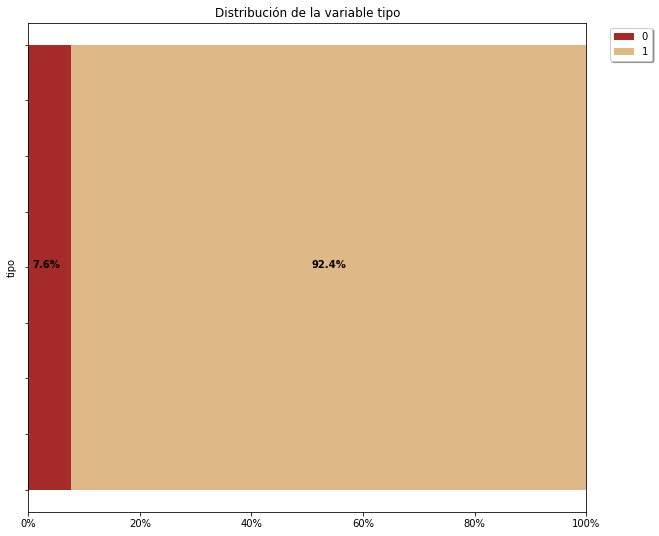

In [4]:
distribucion_variable_predecir(datos,"tipo")

In [5]:
def indices_general(MC, nombres = None):
    precision_global = np.sum(MC.diagonal()) / np.sum(MC)
    error_global = 1 - precision_global
    precision_categoria  = pd.DataFrame(MC.diagonal()/np.sum(MC,axis = 1)).T
    precision_positiva = MC[1][1]/(MC[1][1] + MC[1][0])
    precision_negativa = MC[0][0]/(MC[0][0] + MC[0][1])
    falsos_positivos = 1 - precision_negativa
    falsos_negativos = 1 - precision_positiva
    asertividad_positiva = MC[1][1]/(MC[0][1] + MC[1][1])
    asertividad_negativa = MC[0][0]/(MC[0][0] + MC[1][0])
    if nombres!=None:
        precision_categoria.columns = nombres
    return {"Matriz de Confusión":MC, 
            "Precisión Global":precision_global, 
            "Error Global":error_global, 
            "Precisión por categoría":precision_categoria,
            "Precision Positiva (PP)": precision_positiva, 
            "Precision Negativa (PN)":precision_negativa, 
            "Falsos Positivos(FP)": falsos_positivos,
            "Falsos Negativos (FN)": falsos_negativos,
            "Asertividad Positiva (AP)": asertividad_positiva,
            "Asertividad Negativa (NP)": asertividad_negativa}
    
def poder_predictivo_categorica(data:DataFrame, var:str, variable_predict:str):
    df = pd.crosstab(index= data[var],columns=data[variable_predict])
    df = df.div(df.sum(axis=1),axis=0)
    titulo = "Distribución de la variable %s según la variable %s" % (var,variable_predict)
    g = df.plot(kind='barh',stacked=True,legend = True, figsize = (10,9), \
                xlim = (0,1),title = titulo, width = 0.8)
    vals = g.get_xticks()
    g.set_xticklabels(['{:.0%}'.format(x) for x in vals])
    g.legend(loc='upper center', bbox_to_anchor=(1.08, 1), shadow=True, ncol=1)
    for bars in g.containers:
        plt.setp(bars, width=.9)
    for i in range(df.shape[0]):
        countv = 0 
        for v in df.iloc[i]:
            g.text(np.mean([countv,countv+v]) - 0.03, i , '{:.1%}'.format(v), color='black', fontweight='bold')
            countv = countv + v
            
def poder_predictivo_numerica(data:DataFrame, var:str, variable_predict:str):
    sns.FacetGrid(data, hue=variable_predict, height=6).map(sns.kdeplot, var, shade=True).add_legend()

2. El objetivo de este ejercicio es analizar la variaci´on del error (usando el enfoque trainingtesting) para la predicci´on de variable tipo (que indica 1 = Tumor, 0 = No-Tumor), para esto repita 5 veces el c´alculo de error global de predicci´on usando el m´etodo de los k vecinos m´as cercanos (use kmax=50) y con un 75 % de los datos para tabla aprendizaje y un 25 % para la tabla testing. Grafique los resultados.

In [6]:
X = datos.iloc[:,1:17] 
print(X.head())
y = datos.iloc[:,17:18] 
print(y.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

       media     varianza  desviacion.estandar  entropia  asimetria  \
0  23.448517  2538.985627            50.388348  0.651174   1.984202   
1   4.398331   834.853030            28.893823  0.953532   6.495203   
2   3.244263   642.059166            25.338886  0.966065   7.772860   
3   8.511353  1126.214187            33.559115  0.868765   3.763142   
4  21.000793  2235.316978            47.279139  0.684724   1.936029   

    kurtosis   contraste   energia       asm  homogeneidad  disiminitud  \
0   5.421042  181.467713  0.781557  0.610831      0.847033     2.765411   
1  43.349355   76.745886  0.972770  0.946281      0.980762     0.548605   
2  61.756034   81.752406  0.980161  0.960715      0.985066     0.540411   
3  15.107579  362.291213  0.921786  0.849690      0.949295     2.765725   
4   4.722343  312.439226  0.804184  0.646711      0.880301     3.006660   

   correlacion        psnr      ssim       mse        dc  
0     0.968576   97.974630  0.777011  0.171163  0.303989  
1   

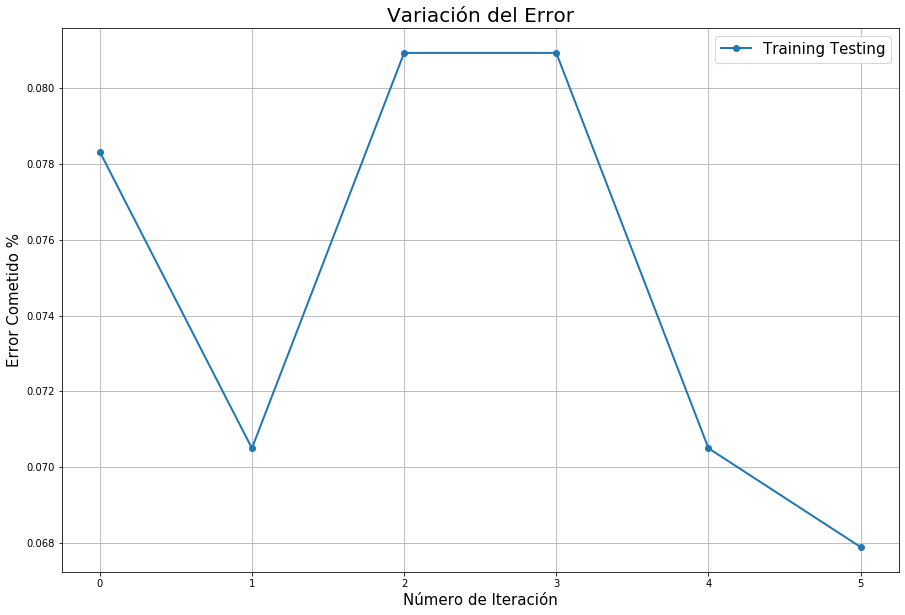

In [7]:
error_tt = []
for i in range(0, 6):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7)
    knn = KNeighborsClassifier(n_neighbors = 50)
    knn.fit(X_train, y_train.values.ravel())
    error_tt.append(1 - knn.score(X_test, y_test))
  
plt.figure(figsize=(15,10))
plt.plot(error_tt, 'o-', lw = 2)
plt.xlabel("Número de Iteración", fontsize = 15)
plt.ylabel("Error Cometido %", fontsize = 15)
plt.title("Variación del Error", fontsize = 20)
plt.grid(True)
plt.legend(['Training Testing'], loc = 'upper right', fontsize = 15)

Con el enfoque de tabla completa

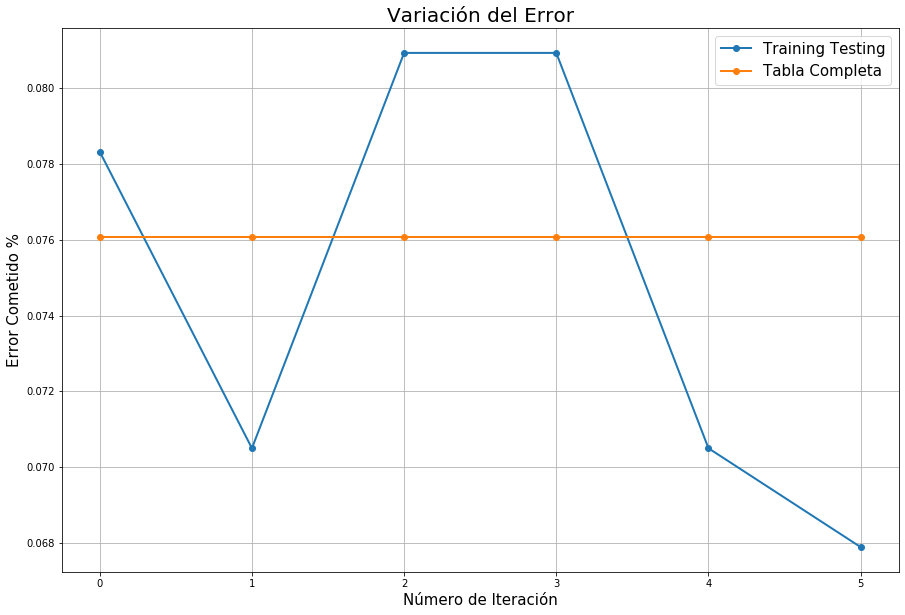

In [8]:
error_tc = []

for i in range(0, 6):
    knn = KNeighborsClassifier(n_neighbors = 50)
    knn.fit(X, y.values.ravel())
    
    error_tc.append(1 - knn.score(X, y))

plt.figure(figsize=(15,10))
plt.plot(error_tt, 'o-', lw = 2)
plt.plot(error_tc, 'o-', lw = 2)
plt.xlabel("Número de Iteración", fontsize = 15)
plt.ylabel("Error Cometido %", fontsize = 15)
plt.title("Variación del Error", fontsize = 20)
plt.grid(True)
plt.legend(['Training Testing', 'Tabla Completa'], loc = 'upper right', fontsize = 15)

3. El objetivo de este ejercicio es medir el error para la predicci´on de variable tipo, utilizando validaci´on cruzada con K grupos (K−fold cross-validation). Para esto usando el m´etodo de los k vecinos m´as cercanos (use kmax=50) realice una validaci´on cruzada 5 veces con 10 grupos (folds) y grafique el error obtenido en cada iteraci´on, agregue en este gr´afico los 5 errores generados en el ejercicio anterior.

In [11]:
n = datos.shape[0]
error_loo = []

for i in range(0, 6):
    error_i = 0
    
    for j in range(0, n): 
        X_train = X.drop(j, axis = 0)
        X_test = X.iloc[j, :]
        y_train = y.drop(j, axis = 0)
        y_test = y.iloc[j]
        
        knn = KNeighborsClassifier(n_neighbors = 8)
        knn.fit(X_train, y_train.values.ravel())
        prediccion = knn.predict(pd.DataFrame(X_test).T)
               
        if(prediccion != y_test[0]):
            error_i = error_i + 1
        
    error_loo.append(error_i / n)

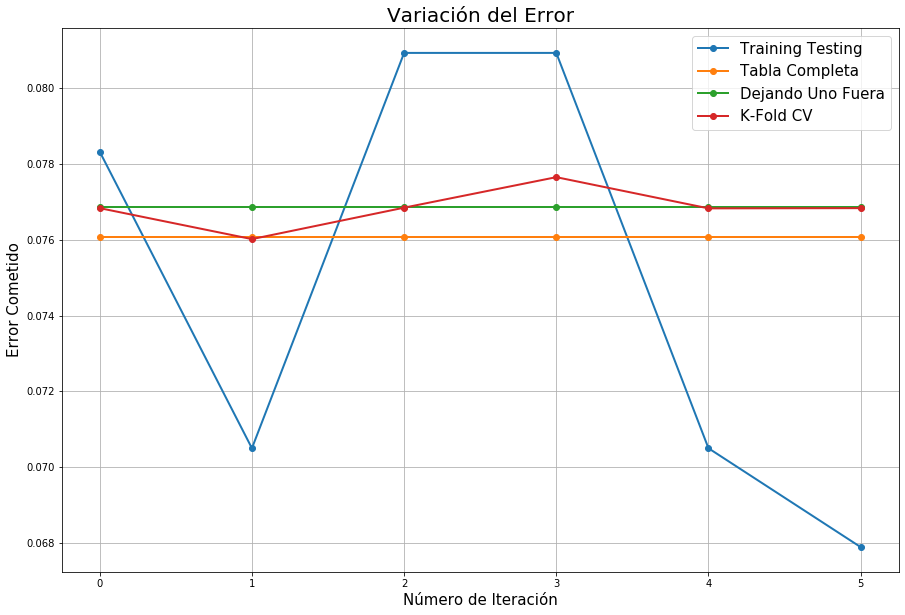

In [12]:
error_cv = []

for i in range(0, 6):
    kfold = KFold(n_splits = 10, shuffle = True)
    error_folds = []

    for train, test in kfold.split(X, y):
        knn = KNeighborsClassifier(n_neighbors = 8)
        knn.fit(X.iloc[train], y.iloc[train].values.ravel())
        error_folds.append((1 - knn.score(X.iloc[test], y.iloc[test])))
        
    error_cv.append(np.mean(error_folds))

plt.figure(figsize=(15,10))
plt.plot(error_tt, 'o-', lw = 2)
plt.plot(error_tc, 'o-', lw = 2)
plt.plot(error_loo, 'o-', lw = 2)
plt.plot(error_cv, 'o-', lw = 2)
plt.xlabel("Número de Iteración", fontsize = 15)
plt.ylabel("Error Cometido", fontsize = 15)
plt.title("Variación del Error", fontsize = 20)
plt.grid(True)
plt.legend(['Training Testing', 'Tabla Completa', 'Dejando Uno Fuera', 'K-Fold CV'], loc = 'upper right', fontsize = 15)

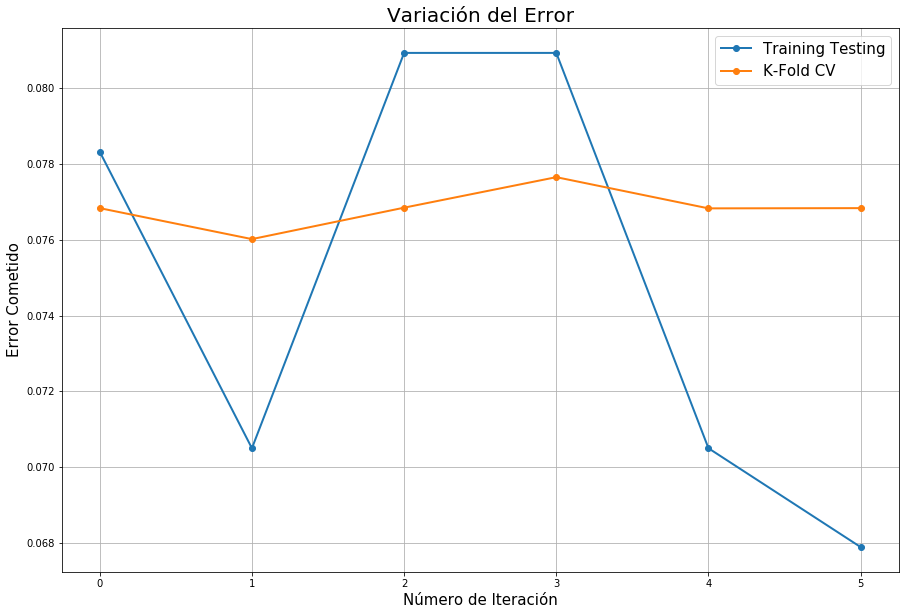

In [13]:
plt.figure(figsize=(15,10))
plt.plot(error_tt, 'o-', lw = 2)
plt.plot(error_cv, 'o-', lw = 2)
plt.xlabel("Número de Iteración", fontsize = 15)
plt.ylabel("Error Cometido", fontsize = 15)
plt.title("Variación del Error", fontsize = 20)
plt.grid(True)
plt.legend(['Training Testing', 'K-Fold CV'], loc = 'upper right', fontsize = 15)

4. ¿Qu´e se puede concluir?

Aqui se denota que tomando 5 iteraciones ya con el table testing con k grupos en k vecinos se denota que genera variaciones en error estimado variables en cada uno de los casos. De 0,068 a 0,085 en las iteracion 5. El metodo de k-fold muestra menores variacionesentre iteracion. Asi mismo si incluimos el promedio de la tabla completa este esta en alrededor de 0,076, y agregando aunque el ejercicio no lo requiere el leave one out el ejercicio denota que este metodo es mas equilibrado. En terminos generales, este caso muestra un error estable, por lo que parece que el error estimado se debe encontrar en un rango en realidad analizando las cifras, no tan variable.

Ejercicio 2: [25 puntos] Para esta pregunta tambi´en usaremos los datos tumores.csv.

1. El objetivo de este ejercicio es calibrar el m´etodo de RandomForestClassifier para esta Tabla de Datos. Aqu´ı interesa predecir en la variable tipo. Para esto genere Validaciones Cruzadas con 10 grupos calibrando el modelo de acuerdo con los dos tipos de criterios que este permite para medir la calidad de cada divisi´on en los ´arboles, es decir, con gini y entropy. Para esto utilice KFold de sklearn y realice un gr´afico comparativo de barras.

In [14]:
instancia_kfold = KFold(n_splits=10)
porcentajes = cross_val_score(RandomForestClassifier(n_estimators=10, random_state=0, criterion='gini'), X, y.iloc[:,0].values, cv=instancia_kfold)
print("Porcentaje de detección por grupo:\n{}".format(porcentajes))
res_gini = porcentajes.mean()
print("Promedio de detección: {:.2f}".format(porcentajes.mean()))

Porcentaje de detección por grupo:
[1.         0.984375   1.         0.9921875  0.984375   0.99212598
 0.99212598 1.         0.99212598 0.98425197]
Promedio de detección: 0.99


In [15]:
instancia_kfold = KFold(n_splits=10)
porcentajes = cross_val_score(RandomForestClassifier(n_estimators=10, random_state=0, criterion='entropy'), X, y.iloc[:,0].values, cv=instancia_kfold)
print("Porcentaje de detección por grupo:\n{}".format(porcentajes))
res_entropy = porcentajes.mean()
print("Promedio de detección: {:.2f}".format(porcentajes.mean()))

Porcentaje de detección por grupo:
[1.         0.984375   0.9921875  1.         0.984375   0.99212598
 0.99212598 1.         0.99212598 0.97637795]
Promedio de detección: 0.99


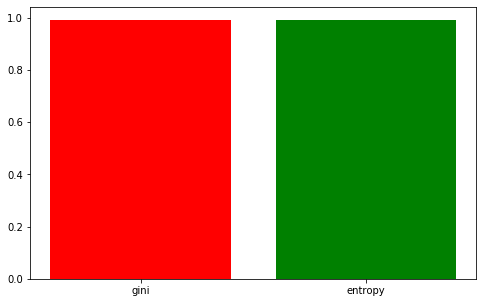

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,5))
alto = [res_gini, res_entropy]
barras = ('gini','entropy')
y_pos = np.arange(len(barras))
plt.bar(y_pos, alto, color=['red', 'green'])
plt.xticks(y_pos, barras)
plt.show()

2. ¿Cu´al algoritmo usar´ıa con base en la informaci´on obtenida en los dos ejercicios anteriores?

Ambos ejercicios identifican el mismo promedio de deteccion tal como se ve en el grafico comparativo, aun asi por grupo este porcentaje varia significativamente. Cabe senalar dentro de este que la deteccion mas baja se da con entropy en 0.97637795, ademas este criterio presenta por lo tanto tambien mas variabilidad en procentajes de deteccion. Por ello, desde un criterio experto personal usaria el criterio de gini.

Ejercicio 3: [25 puntos] Para esta pregunta tambi´en usaremos los datos tumores.csv.

1. El objetivo de este ejercicio es calibrar el m´etodo de KNeighborsClassifier para esta Tabla de Datos. Aqu´ı interesa predecir en la variable tipo. Para esto genere Validaciones Cruzadas con 5 grupos calibrando el modelo de acuerdo con todos los tipos de algoritmos que permite auto, ball tree, kd tree y brute en el par´ametro algorithm. Realice un gr´afico de barras comparativo. ¿Se puede determinar con claridad cu´al algoritmo es el mejor? Utilice KFold de sklearn?

In [17]:
instancia_kfold = KFold(n_splits=5)
porcentajes = cross_val_score(KNeighborsClassifier(n_neighbors=5, algorithm='auto'), X, y.iloc[:,0].values, cv=instancia_kfold)
print("Porcentaje de detección por grupo:\n{}".format(porcentajes))
res_auto = porcentajes.mean()
print("Promedio de detección: {:.2f}".format(porcentajes.mean()))

Porcentaje de detección por grupo:
[0.91372549 0.9372549  0.94117647 0.94509804 0.8627451 ]
Promedio de detección: 0.92


In [18]:
instancia_kfold = KFold(n_splits=5)
porcentajes = cross_val_score(KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree'), X, y.iloc[:,0].values, cv=instancia_kfold)
print("Porcentaje de detección por grupo:\n{}".format(porcentajes))
res_ball = porcentajes.mean()
print("Promedio de detección: {:.2f}".format(porcentajes.mean()))

Porcentaje de detección por grupo:
[0.91372549 0.9372549  0.94117647 0.94509804 0.8627451 ]
Promedio de detección: 0.92


In [19]:
instancia_kfold = KFold(n_splits=5)
porcentajes = cross_val_score(KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree'), X, y.iloc[:,0].values, cv=instancia_kfold)
print("Porcentaje de detección por grupo:\n{}".format(porcentajes))
res_kd = porcentajes.mean()
print("Promedio de detección: {:.2f}".format(porcentajes.mean()))

Porcentaje de detección por grupo:
[0.91372549 0.9372549  0.94117647 0.94509804 0.8627451 ]
Promedio de detección: 0.92


In [20]:
instancia_kfold = KFold(n_splits=5)
porcentajes = cross_val_score(KNeighborsClassifier(n_neighbors=5, algorithm='brute'), X, y.iloc[:,0].values, cv=instancia_kfold)
print("Porcentaje de detección por grupo:\n{}".format(porcentajes))
res_brute = porcentajes.mean()
print("Promedio de detección: {:.2f}".format(porcentajes.mean()))

Porcentaje de detección por grupo:
[0.91372549 0.9372549  0.94117647 0.94509804 0.8627451 ]
Promedio de detección: 0.92


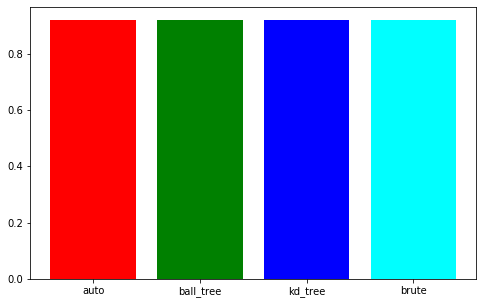

In [22]:
plt.figure(figsize=(8,5))
alto = [res_auto,res_ball,res_kd,res_brute]
barras = ('auto','ball_tree','kd_tree','brute')
y_pos = np.arange(len(barras))
plt.bar(y_pos, alto, color=['red', 'green', 'blue', 'cyan'])
plt.xticks(y_pos, barras)
plt.show()

Los cuatro algoritmos muestran exactamente los mismos resultados en sus cuatro algoritmos.

2. ¿Cu´al algoritmo usar´ıa con base en la informaci´on obtenida en los dos ejercicios anteriores?

La informacion muestra que el mejor porcentaje de deteccion lo tiene RandomForestClassifier, por lo que se eligiria este algoritmo con criterio gini.

Ejercicio 4: [25 puntos] Para esta pregunta tambi´en usaremos los datos tumores.csv.

1. El objetivo de este ejercicio es comparar todos los m´etodos predictivos vistos en el curso con esta tabla de datos. Aqu´ı interesa predecir en la variable tipo. Para esto genere Validaciones Cruzadas con 5 grupos para los m´etodos SVM, KNN, ´Arboles, Bosques, ADA Boosting, eXtreme Gradient Boosting, Bayes, LDA, QDA y Redes Neuronales del paquete MLPClassifier. Para KNN y Bosques use los par´ametros obtenidos en las calibraciones realizadas en los ejercicios anteriores (en teor´ıa se deber´ıan calibrar todos los m´etodos). Luego realice un gr´afico de barras para comparar los m´etodos. ¿Se puede determinar con claridad cu´al m´etodos es el mejor? Utilice KFold de sklearn.

In [23]:
from sklearn.neighbors import KNeighborsClassifier
instancia_kfold = KFold(n_splits=5)
porcentajes = cross_val_score(KNeighborsClassifier(n_neighbors=5), X, y.iloc[:,0].values, cv=instancia_kfold)
print("Porcentaje de detección por grupo:\n{}".format(porcentajes))
res_knn = porcentajes.mean()
print("Promedio de detección: {:.2f}".format(porcentajes.mean()))

Porcentaje de detección por grupo:
[0.91372549 0.9372549  0.94117647 0.94509804 0.8627451 ]
Promedio de detección: 0.92


In [24]:
from sklearn.tree import DecisionTreeClassifier
instancia_kfold = KFold(n_splits=5)
porcentajes = cross_val_score(DecisionTreeClassifier(), X, y.iloc[:,0].values, cv=instancia_kfold)
print("Porcentaje de detección por grupo:\n{}".format(porcentajes))
res_arbol = porcentajes.mean()
print("Promedio de detección: {:.2f}".format(porcentajes.mean()))

Porcentaje de detección por grupo:
[0.98431373 0.98431373 0.98039216 0.98823529 0.96470588]
Promedio de detección: 0.98


In [25]:
from sklearn.ensemble import RandomForestClassifier
instancia_kfold = KFold(n_splits=5)
porcentajes = cross_val_score(RandomForestClassifier(n_estimators=5, random_state=0, criterion='gini'), X, y.iloc[:,0].values, cv=instancia_kfold)
print("Porcentaje de detección por grupo:\n{}".format(porcentajes))
res_bosques = porcentajes.mean()
print("Promedio de detección: {:.2f}".format(porcentajes.mean()))

Porcentaje de detección por grupo:
[0.98823529 0.98823529 0.98431373 0.99607843 0.98431373]
Promedio de detección: 0.99


In [26]:
from sklearn.ensemble import AdaBoostClassifier
instancia_kfold = KFold(n_splits=5)
porcentajes = cross_val_score(AdaBoostClassifier(n_estimators=5), X, y.iloc[:,0].values, cv=instancia_kfold)
print("Porcentaje de detección por grupo:\n{}".format(porcentajes))
res_potenciacion = porcentajes.mean()
print("Promedio de detección: {:.2f}".format(porcentajes.mean()))

Porcentaje de detección por grupo:
[0.98431373 0.98431373 0.98431373 0.98823529 0.98039216]
Promedio de detección: 0.98


In [27]:
from sklearn.ensemble import GradientBoostingClassifier
instancia_kfold = KFold(n_splits=5)
porcentajes = cross_val_score(GradientBoostingClassifier(n_estimators=5), X, y.iloc[:,0].values, cv=instancia_kfold)
print("Porcentaje de detección por grupo:\n{}".format(porcentajes))
res_xg_potenciacion = porcentajes.mean()
print("Promedio de detección: {:.2f}".format(porcentajes.mean()))

Porcentaje de detección por grupo:
[0.91764706 0.96862745 0.94901961 0.94509804 0.87058824]
Promedio de detección: 0.93


In [28]:
instancia_kfold = KFold(n_splits=5)
porcentajes = cross_val_score(SVC(kernel='rbf', gamma = 'scale'), X, y.iloc[:,0].values, cv=instancia_kfold)
print("Porcentaje de detección por grupo:\n{}".format(porcentajes))
res_svm = porcentajes.mean()
print("Promedio de detección: {:.2f}".format(porcentajes.mean()))

Porcentaje de detección por grupo:
[0.91764706 0.9372549  0.94901961 0.94509804 0.87058824]
Promedio de detección: 0.92


In [29]:
from sklearn.neural_network import MLPClassifier
instancia_kfold = KFold(n_splits=5)
porcentajes = cross_val_score(MLPClassifier(solver='lbfgs'), X, y.iloc[:,0].values, cv=instancia_kfold)
print("Porcentaje de detección por grupo:\n{}".format(porcentajes))
res_redes_MLP = porcentajes.mean()
print("Promedio de detección: {:.2f}".format(porcentajes.mean()))

Porcentaje de detección por grupo:
[0.86666667 0.80392157 0.81176471 0.64705882 0.85098039]
Promedio de detección: 0.80


In [30]:
from sklearn.naive_bayes import GaussianNB
instancia_kfold = KFold(n_splits=5)
porcentajes = cross_val_score(GaussianNB(), X, y.iloc[:,0].values, cv=instancia_kfold)
print("Porcentaje de detección por grupo:\n{}".format(porcentajes))
res_bayes = porcentajes.mean()
print("Promedio de detección: {:.2f}".format(porcentajes.mean()))

Porcentaje de detección por grupo:
[0.89019608 0.88627451 0.9372549  0.89803922 0.79607843]
Promedio de detección: 0.88


In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
instancia_kfold = KFold(n_splits=5)
porcentajes = cross_val_score(LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 'auto'), X, y.iloc[:,0].values, cv=instancia_kfold)
print("Porcentaje de detección por grupo:\n{}".format(porcentajes))
res_dis_lineal = porcentajes.mean()
print("Promedio de detección: {:.2f}".format(porcentajes.mean()))

Porcentaje de detección por grupo:
[0.95686275 0.96470588 0.97254902 0.95294118 0.94117647]
Promedio de detección: 0.96


In [32]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
instancia_kfold = KFold(n_splits=5)
porcentajes = cross_val_score(QuadraticDiscriminantAnalysis(), X, y.iloc[:,0].values, cv=instancia_kfold)
print("Porcentaje de detección por grupo:\n{}".format(porcentajes))
res_dis_cuadratico = porcentajes.mean()
print("Promedio de detección: {:.2f}".format(porcentajes.mean()))

Porcentaje de detección por grupo:
[0.08235294 0.0627451  0.05098039 0.05490196 0.12941176]
Promedio de detección: 0.08


C:\Users\rzamoram\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\rzamoram\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\rzamoram\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\rzamoram\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:718: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
C:\Users\rzamoram\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users

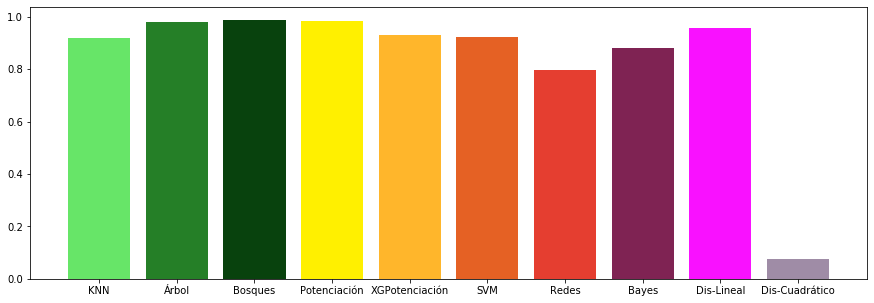

In [33]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,5))
alto = [res_knn,res_arbol,res_bosques,res_potenciacion,res_xg_potenciacion,res_svm,res_redes_MLP,res_bayes,res_dis_lineal,res_dis_cuadratico]
barras = ('KNN','Árbol','Bosques','Potenciación','XGPotenciación','SVM','Redes','Bayes','Dis-Lineal','Dis-Cuadrático')
y_pos = np.arange(len(barras))
plt.bar(y_pos, alto,color = ["#67E568","#257F27","#08420D","#FFF000","#FFB62B","#E56124","#E53E30","#7F2353","#F911FF","#9F8CA6"])
plt.xticks(y_pos, barras)
plt.show()

Viendo el grafico se denota que arboles, bosques, potenciacion y LDA tiene alto Promedio de detección, pero al observar los valores estimados se denota que finalmente es bosques aleatorios, se prefiere gini pero entropy tambien funciona igual, con un porcentaje de deteccion del 99% el que mejor prediccion global tiene.

2. ¿Se podr´a incluir en esta selecci´on las Redes Neuronales del paquete Keras? Si la respuesta es que s´ı entonces incluyalo.

In [40]:
from sklearn.neural_network import MLPClassifier
instancia_kfold = KFold(n_splits=5)
porcentajes = cross_val_score(MLPClassifier(solver='lbfgs'), X, y.iloc[:,0].values, cv=instancia_kfold)
print("Porcentaje de detección por grupo:\n{}".format(porcentajes))
res_redes_MLP = porcentajes.mean()
print("Promedio de detección: {:.2f}".format(porcentajes.mean()))

Porcentaje de detección por grupo:
[0.91372549 0.19215686 0.90980392 0.81568627 0.81960784]
Promedio de detección: 0.73


In [34]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(10, input_dim = 16, activation = 'relu')) 
model.add(Dense(10, activation = 'relu'))  
model.add(Dense(10, activation = 'relu'))  
model.add(Dense(5, activation = 'sigmoid')) 
model.add(Dense(1, activation = 'sigmoid')) 
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                170       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
scores = model.evaluate(X, y, verbose=0)
instancia_kfold = KFold(n_splits=5)
porcentajes = cross_val_score(model, X, y.iloc[:,0].values, cv=instancia_kfold)


TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x000002033B24CDC8> does not.

In [41]:
print("Porcentaje de detección por grupo:\n{}".format(porcentajes))
res_keras = porcentajes.mean()
print("Promedio de detección: {:.2f}".format(porcentajes.mean()))

Porcentaje de detección por grupo:
[0.91372549 0.19215686 0.90980392 0.81568627 0.81960784]
Promedio de detección: 0.73


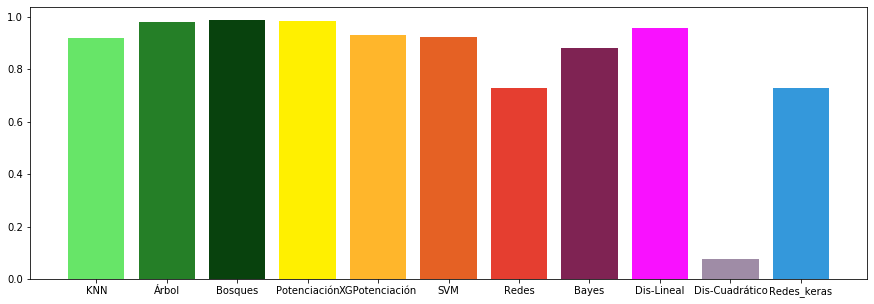

In [43]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,5))
alto = [res_knn,res_arbol,res_bosques,res_potenciacion,res_xg_potenciacion,res_svm,res_redes_MLP,res_bayes,res_dis_lineal,res_dis_cuadratico, res_keras]
barras = ('KNN','Árbol','Bosques','Potenciación','XGPotenciación','SVM','Redes','Bayes','Dis-Lineal','Dis-Cuadrático', 'Redes_keras')
y_pos = np.arange(len(barras))
plt.bar(y_pos, alto,color = ["#67E568","#257F27","#08420D","#FFF000","#FFB62B","#E56124","#E53E30","#7F2353","#F911FF","#9F8CA6", "#3498db"])
plt.xticks(y_pos, barras)
plt.show()

Si se logro incluir keres redes en el grafico, a pesar de que no es tan simple como con los otros modelos que ya python los trae estimados por default.

3. ¿Cu´al m´etodo usar´ıa con base en la informaci´on obtenida en los dos ejercicios anteriores?

El mejor modelo continua siendo Bosques Aleatorios con una precision global alta, aunque como se indicaba otros metodos tambien muestran precision global bastante elevada y cercana a bosques.